<a href="https://colab.research.google.com/github/Sajad-Adil/Time-Series-Classification-using-Machine-Learning-on-EEG-Data/blob/main/EEG_Signal_Classification_(3_classes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tsfresh

####Import libraries

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm, feature_selection, model_selection, pipeline, preprocessing, metrics, datasets, neighbors, tree, ensemble, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import pipeline
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures


#### Unzip dataset

In [ ]:
# this code will just extract data from BonnDataset zip file

# Path to the zip file
zip_path = '/content/BonnDataset.zip'
extract_dir = '/content/Bonn_data'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

##Automated (Loading, pre-processing, and feature extraction)



### Load the Dataset



In [ ]:
def read_txt_files_to_df(folder_path):

    records = []


    for filename in os.listdir(folder_path):
        if filename.endswith('.txt') or filename.endswith('.TXT'):
            file_path = os.path.join(folder_path, filename)

            with open(file_path, 'r') as file:
                content = file.readlines()

                samples = [float(line.strip()) for line in content]
                if len(samples) == 4097:
                    records.append(samples)
                else:
                    print(f"File {filename} does not contain exactly 4097 samples. Skipping this file.")

    # Create a DataFrame from the list of records
    df = pd.DataFrame(records)

    return df

# Example usage




In [ ]:


df0 = read_txt_files_to_df('/content/Bonn_data/Z')
df0['class'] = 0
df1 = read_txt_files_to_df('/content/Bonn_data/O')

df1['class'] = 0
df2 = read_txt_files_to_df('/content/Bonn_data/N')
df2['class'] = 1
df3 = read_txt_files_to_df('/content/Bonn_data/F')
df3['class'] = 1
df4 = read_txt_files_to_df('/content/Bonn_data/S')
df4['class'] = 2


In [ ]:
df0 = pd.concat([df0, df1], axis=0) #
df1 = pd.concat([df2, df3], axis=0)
df2 = pd.concat([df4], axis=0)

In [ ]:
combined_data = pd.concat([df0, df1, df2], axis=0)

In [ ]:
combined_data.reset_index(drop=True, inplace=True)


In [ ]:
combined_data

,0,1,2,3,4,5,6,7,8,9,...,4088,4089,4090,4091,4092,4093,4094,4095,4096,class
0,36.0,27.0,24.0,12.0,6.0,-11.0,-22.0,-21.0,-10.0,-3.0,...,32.0,65.0,97.0,100.0,88.0,80.0,66.0,59.0,6.0,0
1,-55.0,-32.0,1.0,36.0,74.0,108.0,110.0,93.0,60.0,45.0,...,3.0,-17.0,-35.0,-59.0,-76.0,-85.0,-73.0,-65.0,-39.0,0
2,-44.0,-35.0,-18.0,2.0,-5.0,2.0,-7.0,-20.0,-1.0,-1.0,...,-3.0,-32.0,-2.0,31.0,43.0,65.0,44.0,55.0,66.0,0
3,-20.0,-3.0,2.0,16.0,29.0,36.0,34.0,29.0,38.0,26.0,...,-42.0,-32.0,-34.0,-25.0,-27.0,-34.0,-28.0,-10.0,3.0,0
4,-19.0,-1.0,33.0,51.0,49.0,26.0,-15.0,-42.0,-45.0,-37.0,...,-14.0,-25.0,-19.0,-28.0,-49.0,-71.0,-70.0,-25.0,-2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,23.0,144.0,228.0,260.0,255.0,218.0,178.0,126.0,60.0,6.0,...,-127.0,-123.0,-152.0,-231.0,-272.0,-272.0,-155.0,6.0,-221.0,2
496,80.0,86.0,91.0,100.0,107.0,116.0,127.0,153.0,207.0,258.0,...,34.0,46.0,48.0,48.0,43.0,42.0,54.0,78.0,89.0,2
497,98.0,88.0,76.0,59.0,40.0,17.0,6.0,-3.0,-5.0,-15.0,...,-301.0,-322.0,-200.0,-29.0,151.0,250.0,244.0,184.0,70.0,2
498,-445.0,-645.0,-652.0,-562.0,-496.0,-442.0,-375.0,-293.0,-218.0,-146.0,...,355.0,347.0,335.0,326.0,313.0,294.0,264.0,219.0,-346.0,2


In [ ]:
combined_data.shape

(500, 4098)

In [ ]:
y = combined_data['class']
y.unique()


array([0, 1, 2])

In [ ]:
y.shape

(500,)

In [ ]:
# copy the combined data
data = combined_data.copy()

In [ ]:
data

,0,1,2,3,4,5,6,7,8,9,...,4088,4089,4090,4091,4092,4093,4094,4095,4096,class
0,36.0,27.0,24.0,12.0,6.0,-11.0,-22.0,-21.0,-10.0,-3.0,...,32.0,65.0,97.0,100.0,88.0,80.0,66.0,59.0,6.0,0
1,-55.0,-32.0,1.0,36.0,74.0,108.0,110.0,93.0,60.0,45.0,...,3.0,-17.0,-35.0,-59.0,-76.0,-85.0,-73.0,-65.0,-39.0,0
2,-44.0,-35.0,-18.0,2.0,-5.0,2.0,-7.0,-20.0,-1.0,-1.0,...,-3.0,-32.0,-2.0,31.0,43.0,65.0,44.0,55.0,66.0,0
3,-20.0,-3.0,2.0,16.0,29.0,36.0,34.0,29.0,38.0,26.0,...,-42.0,-32.0,-34.0,-25.0,-27.0,-34.0,-28.0,-10.0,3.0,0
4,-19.0,-1.0,33.0,51.0,49.0,26.0,-15.0,-42.0,-45.0,-37.0,...,-14.0,-25.0,-19.0,-28.0,-49.0,-71.0,-70.0,-25.0,-2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,23.0,144.0,228.0,260.0,255.0,218.0,178.0,126.0,60.0,6.0,...,-127.0,-123.0,-152.0,-231.0,-272.0,-272.0,-155.0,6.0,-221.0,2
496,80.0,86.0,91.0,100.0,107.0,116.0,127.0,153.0,207.0,258.0,...,34.0,46.0,48.0,48.0,43.0,42.0,54.0,78.0,89.0,2
497,98.0,88.0,76.0,59.0,40.0,17.0,6.0,-3.0,-5.0,-15.0,...,-301.0,-322.0,-200.0,-29.0,151.0,250.0,244.0,184.0,70.0,2
498,-445.0,-645.0,-652.0,-562.0,-496.0,-442.0,-375.0,-293.0,-218.0,-146.0,...,355.0,347.0,335.0,326.0,313.0,294.0,264.0,219.0,-346.0,2


### Convert into appropriate format

In [ ]:
data["id"] = data.index
data = data.drop(['class'], axis=1)
data = data.melt(id_vars='id', var_name="time").sort_values(['id', 'time']).reset_index(drop=True)

In [ ]:
data

,id,time,value
0,0,0,36.0
1,0,1,27.0
2,0,2,24.0
3,0,3,12.0
4,0,4,6.0
...,...,...,...
2048495,499,4092,-10.0
2048496,499,4093,-5.0
2048497,499,4094,-7.0
2048498,499,4095,-7.0


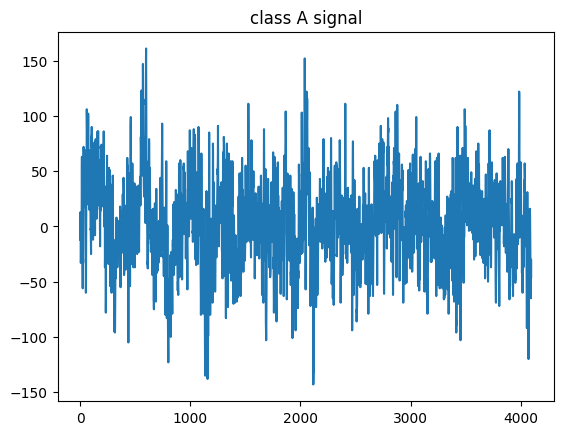

In [ ]:
from matplotlib import pyplot as plt

plt.title('class A signal')
plt.plot(data[data['id'] == 10].set_index('time').value)
plt.show()

###Feature extraction


In [ ]:
EEG_features = extract_features(data, column_id="id", column_sort="time", default_fc_parameters=EfficientFCParameters())

Feature Extraction: 100%|██████████| 500/500 [05:31<00:00,  1.51it/s]


In [ ]:
impute(EEG_features)

/usr/local/lib/python3.10/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__fourier_entropy__bins_5,value__fourier_entropy__bins_10,value__fourier_entropy__bins_100,value__permutation_entropy__dimension_3__tau_1,value__permutation_entropy__dimension_4__tau_1,value__permutation_entropy__dimension_5__tau_1,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,value__mean_n_absolute_max__number_of_maxima_7
0,1.0,0.0,0.0,1.0,24782.0,6619714.0,11.066895,-0.007324,-0.005372,6.0,...,0.622877,0.759436,1.763009,1.458082,2.342914,3.310628,4.336364,5.348855,0.0,134.714286
1,1.0,0.0,0.0,1.0,33392.0,11407306.0,12.745605,0.003906,0.000366,8.0,...,0.262742,0.522487,1.399967,1.456703,2.338284,3.298164,4.303408,5.305347,0.0,227.428571
2,1.0,0.0,0.0,1.0,4191.0,6526241.0,14.558594,0.026855,0.000244,1.0,...,0.492803,0.731788,1.877033,1.629859,2.723394,3.918430,5.173836,6.330136,0.0,139.285714
3,1.0,0.0,0.0,1.0,-8482.0,2901078.0,8.607666,0.005615,-0.000488,-2.0,...,0.334825,0.679618,1.775853,1.558947,2.572826,3.677762,4.832472,5.954081,0.0,88.428571
4,1.0,0.0,0.0,1.0,-19140.0,7973302.0,15.139404,0.004150,0.000611,-5.0,...,0.571267,0.954399,1.865344,1.447064,2.314075,3.254203,4.253166,5.262192,0.0,153.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.0,0.0,0.0,1.0,13447.0,275419177.0,59.614746,-0.059570,-0.042491,-21.0,...,0.204871,0.352599,1.199237,1.236926,1.874444,2.562174,3.284830,4.016319,0.0,929.428571
496,1.0,0.0,0.0,1.0,-66395.0,141273895.0,38.728760,0.002197,0.000611,21.0,...,0.170467,0.307703,1.090237,1.125873,1.635033,2.184782,2.766321,3.356812,0.0,504.142857
497,1.0,0.0,0.0,1.0,-14032.0,69572550.0,24.953613,-0.006836,-0.012698,13.0,...,0.433167,0.666300,1.532356,1.342533,2.088519,2.902404,3.749708,4.595315,0.0,644.000000
498,1.0,0.0,0.0,1.0,-9843.0,540440799.0,69.300537,0.024170,-0.044567,51.0,...,0.243347,0.477200,1.397266,1.170619,1.701343,2.270089,2.871148,3.494580,0.0,1380.285714


In [ ]:
# check for null values
EEG_features.isnull().sum().sum()

0

### Feature selection using tsfresh

In [ ]:
selected_features = select_features(EEG_features, y)

In [ ]:
selected_features.shape

(500, 343)

In [ ]:
y.shape

(500,)

Data Normalization

In [ ]:
scalar= preprocessing.StandardScaler()
xnorm = scalar.fit_transform(selected_features)

##Modeling

### Data split using K fold cross validation

In [ ]:
stratified_shuffled_k_fold = model_selection.StratifiedShuffleSplit(
    n_splits=10, random_state = 42
)

In [ ]:
def kfold_train_test_split(x,y,train_indices,test_indices):
    return x[train_indices], x[test_indices], y[train_indices], y[test_indices]


A function for model evaluation

In [ ]:
def evaluate_model(x, y, model):
  scores = []

  for train_indices, test_indices in stratified_shuffled_k_fold.split(x, y):
    x_train, x_test, y_train, y_test = kfold_train_test_split(x, y, train_indices, test_indices)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
          # Calculate scores
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred,average='weighted')
    precision = metrics.precision_score(y_test, y_pred,average='weighted')
    recall = metrics.recall_score(y_test, y_pred,average='weighted')
      # Create scores dictionary
    scores_dict = {"accuracy": accuracy,"f1": f1, "precision": precision, "recall": recall}
    cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
      # Append to scores array
    scores.append(scores_dict)
  scores_df = pd.DataFrame(scores)


  return scores_df.mean(), scores_df


###Logistic Regression

In [ ]:
logistic_regression=pipeline.Pipeline([
               ('logistic',linear_model.LogisticRegression())])

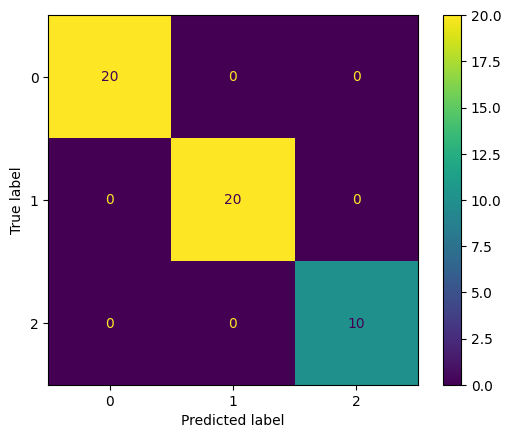

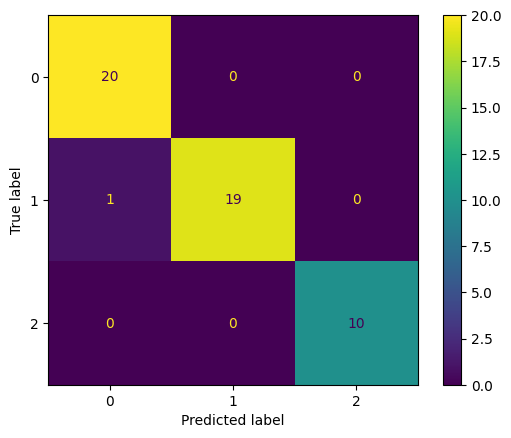

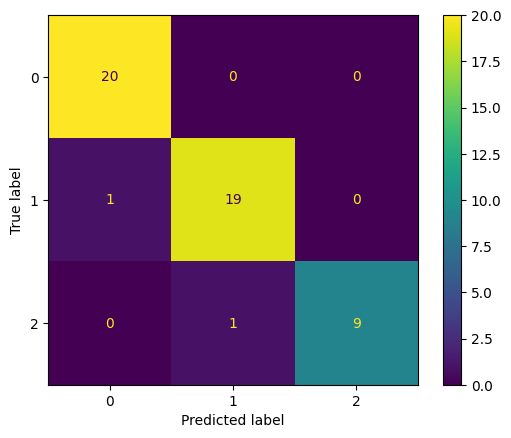

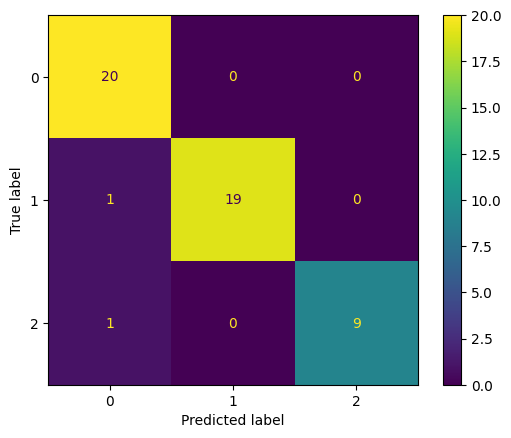

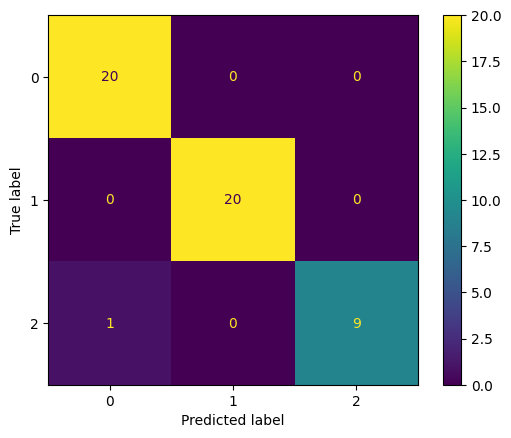

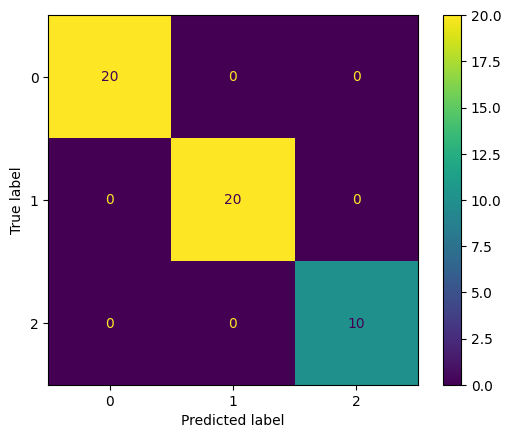

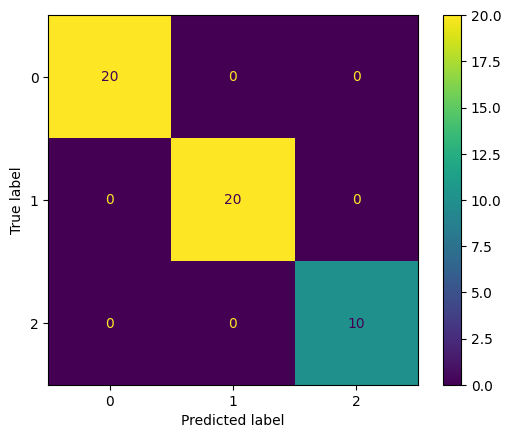

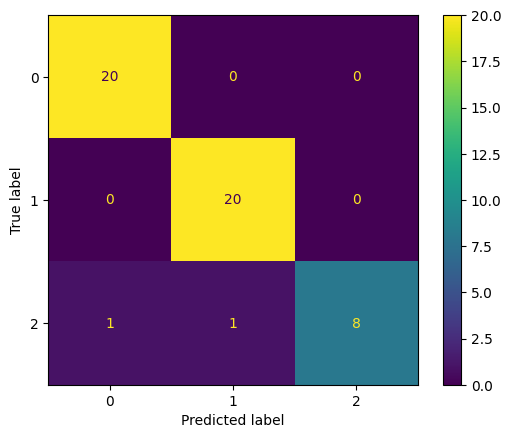

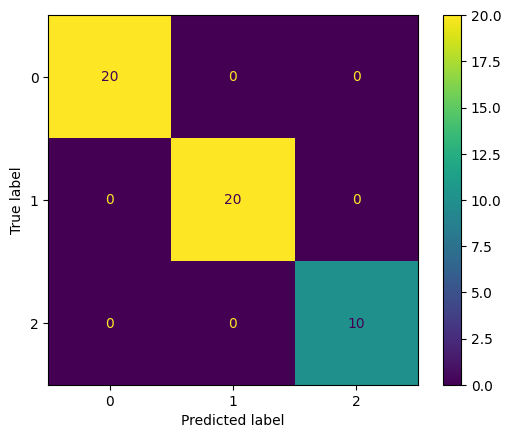

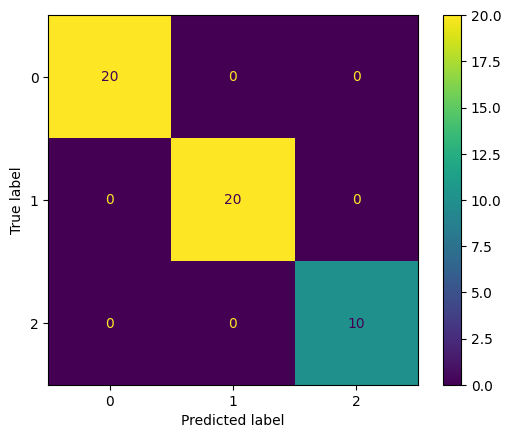

(accuracy     0.984000
 f1           0.983786
 precision    0.984840
 recall       0.984000
 dtype: float64,
    accuracy        f1  precision  recall
 0      1.00  1.000000   1.000000    1.00
 1      0.98  0.979987   0.980952    0.98
 2      0.96  0.959718   0.960952    0.96
 3      0.96  0.960170   0.963636    0.96
 4      0.98  0.979718   0.980952    0.98
 5      1.00  1.000000   1.000000    1.00
 6      1.00  1.000000   1.000000    1.00
 7      0.96  0.958266   0.961905    0.96
 8      1.00  1.000000   1.000000    1.00
 9      1.00  1.000000   1.000000    1.00)

In [ ]:
evaluate_model(xnorm, y, logistic_regression)

###KNN

In [ ]:
from sklearn import neighbors

In [ ]:
knn=pipeline.Pipeline([
               ('model' ,neighbors.KNeighborsClassifier(n_neighbors=5))])

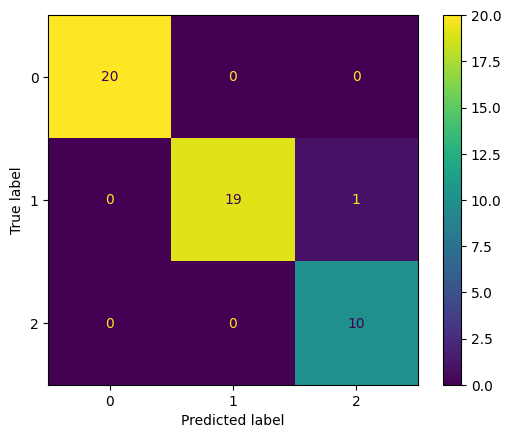

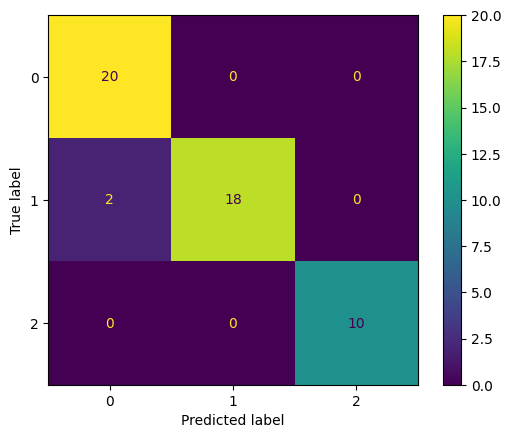

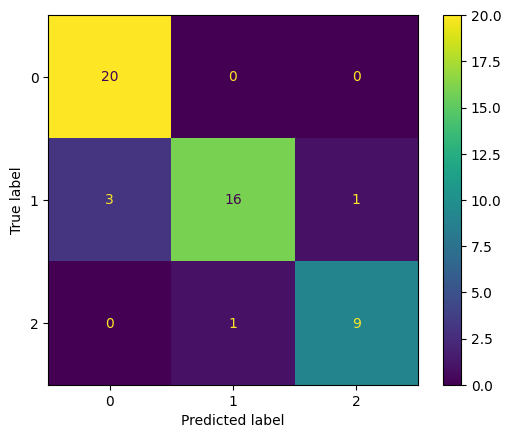

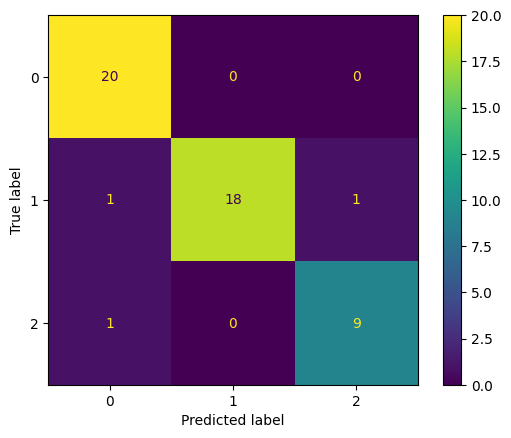

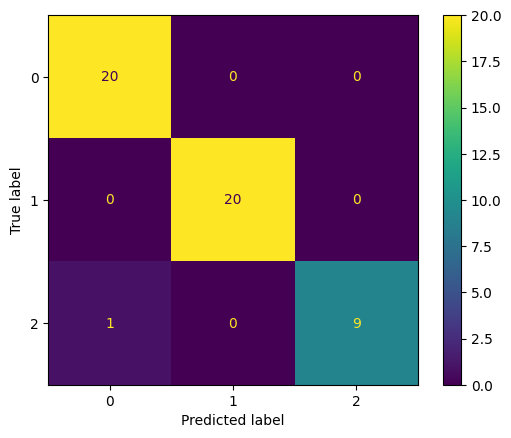

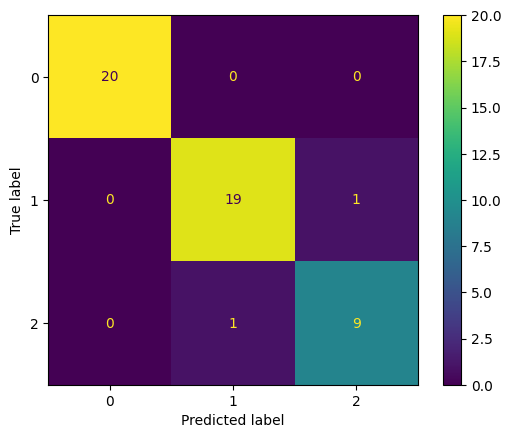

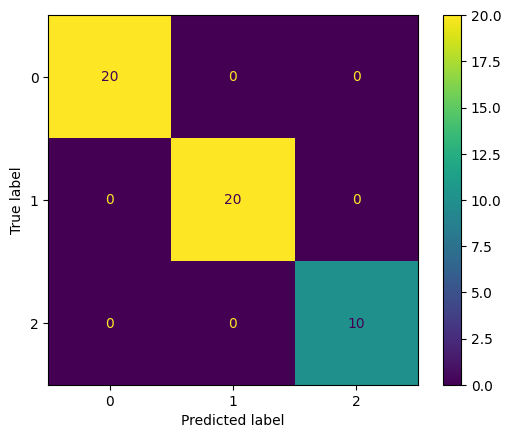

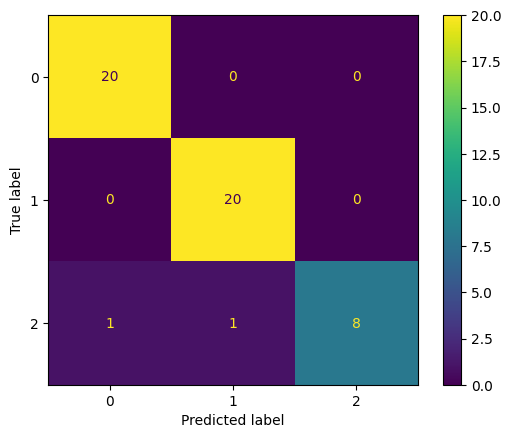

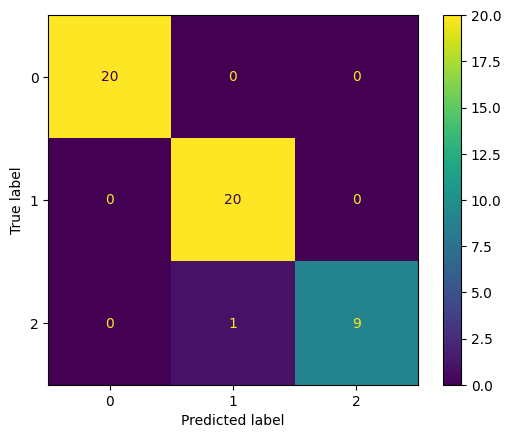

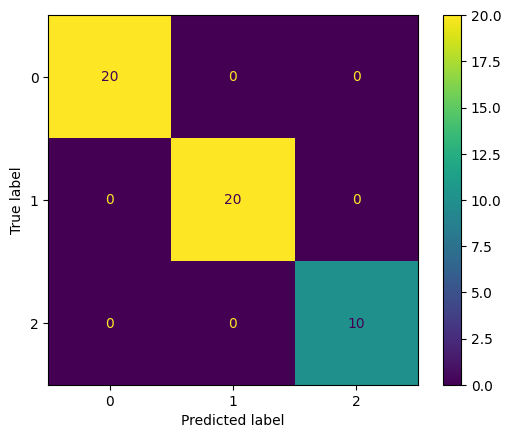

(accuracy     0.966000
 f1           0.965576
 precision    0.967720
 recall       0.966000
 dtype: float64,
    accuracy        f1  precision  recall
 0      0.98  0.980220   0.981818    0.98
 1      0.96  0.959900   0.963636    0.96
 2      0.90  0.898039   0.904297    0.90
 3      0.94  0.939900   0.943636    0.94
 4      0.98  0.979718   0.980952    0.98
 5      0.96  0.960000   0.960000    0.96
 6      1.00  1.000000   1.000000    1.00
 7      0.96  0.958266   0.961905    0.96
 8      0.98  0.979718   0.980952    0.98
 9      1.00  1.000000   1.000000    1.00)

In [ ]:
evaluate_model(xnorm, y, knn)

### KNN with bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(neighbors.KNeighborsClassifier()
                           )

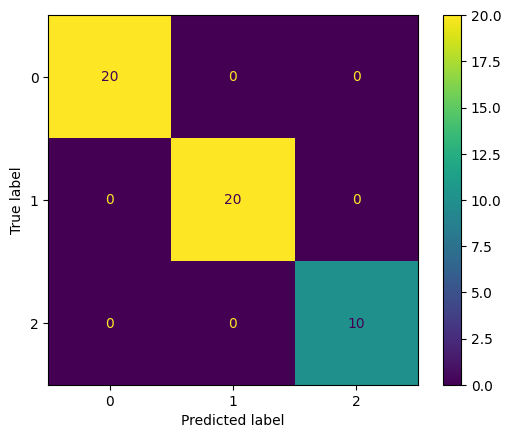

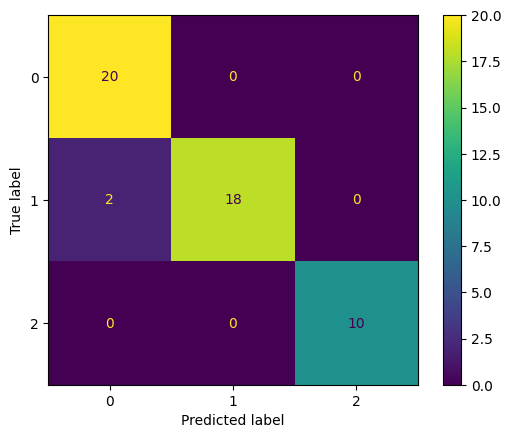

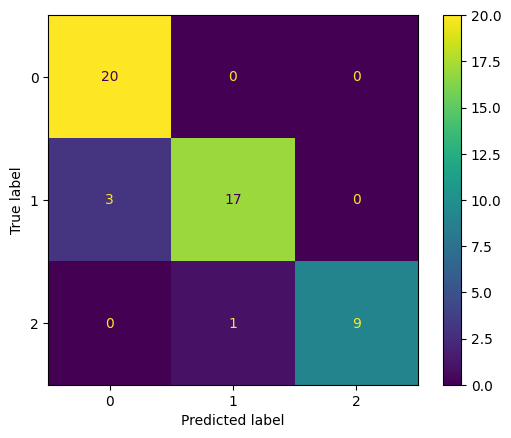

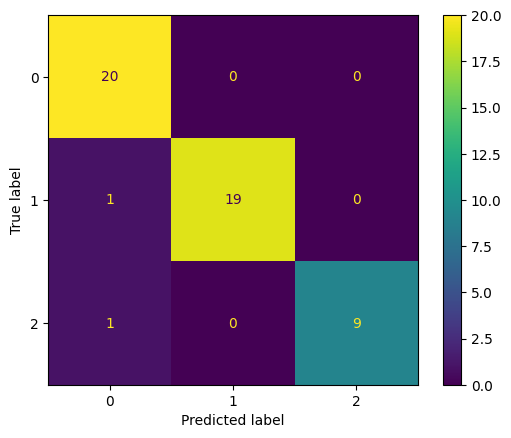

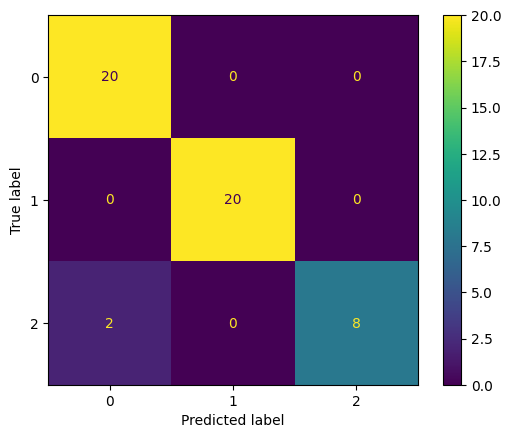

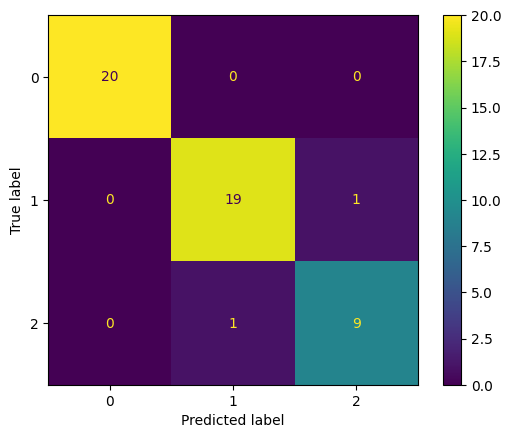

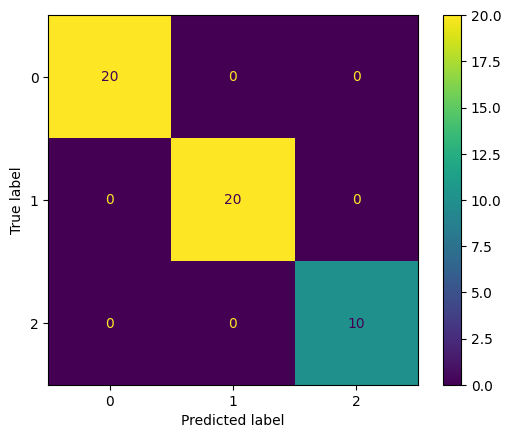

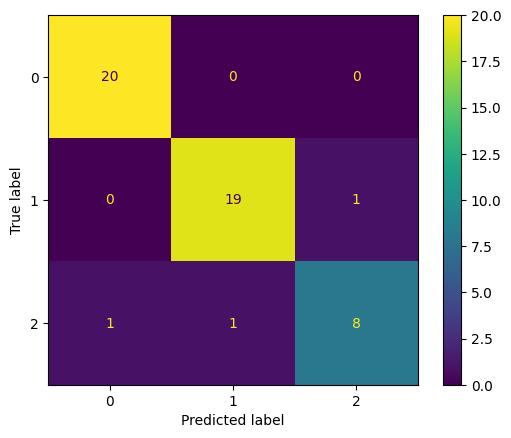

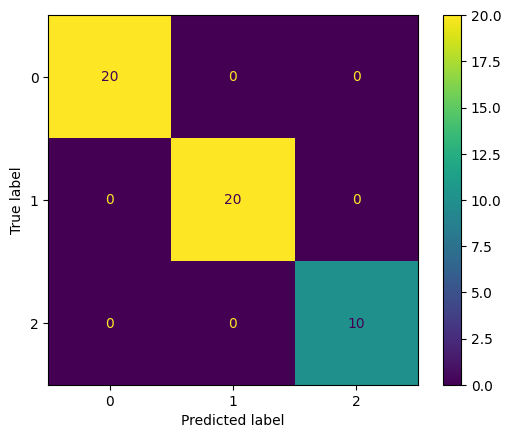

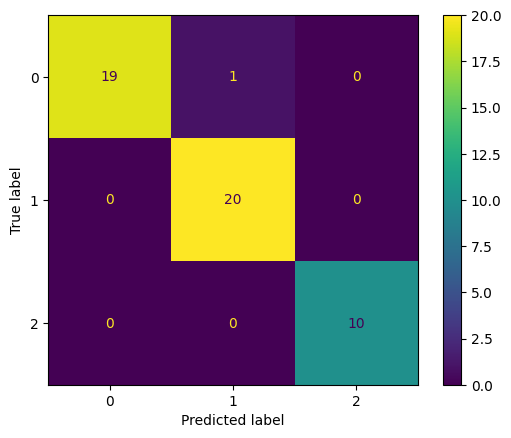

(accuracy     0.968000
 f1           0.967691
 precision    0.969620
 recall       0.968000
 dtype: float64,
    accuracy        f1  precision  recall
 0      1.00  1.000000   1.000000    1.00
 1      0.96  0.959900   0.963636    0.96
 2      0.92  0.919461   0.925604    0.92
 3      0.96  0.960170   0.963636    0.96
 4      0.96  0.958730   0.963636    0.96
 5      0.96  0.960000   0.960000    0.96
 6      1.00  1.000000   1.000000    1.00
 7      0.94  0.938665   0.938730    0.94
 8      1.00  1.000000   1.000000    1.00
 9      0.98  0.979987   0.980952    0.98)

In [ ]:
evaluate_model(xnorm, y, bagging)

###Decision Tree

In [ ]:
decision_tree = tree.DecisionTreeClassifier(criterion='entropy')

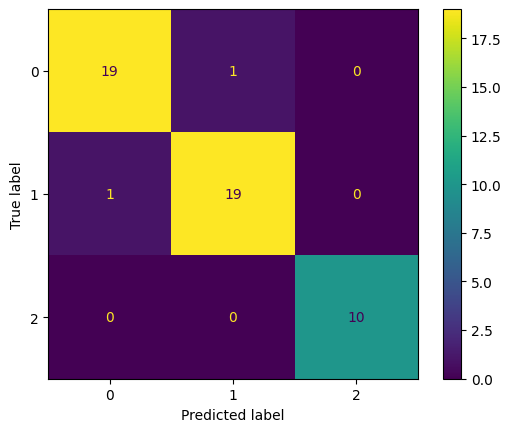

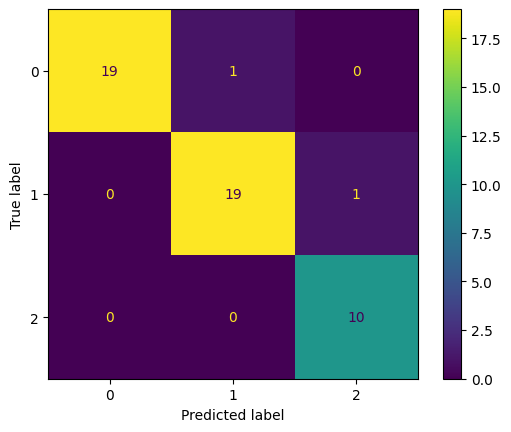

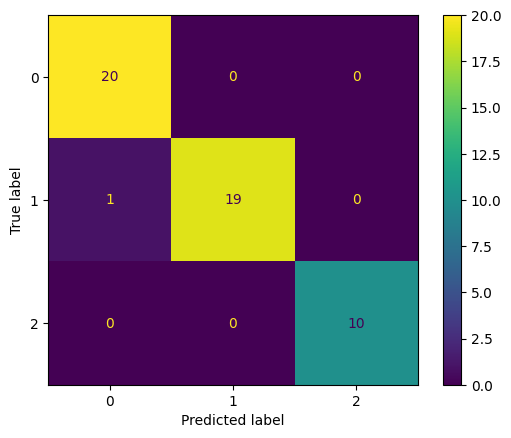

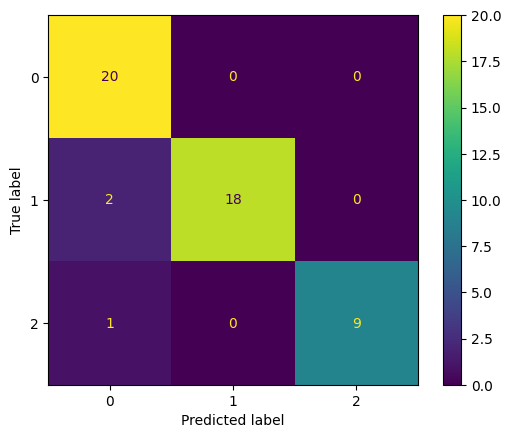

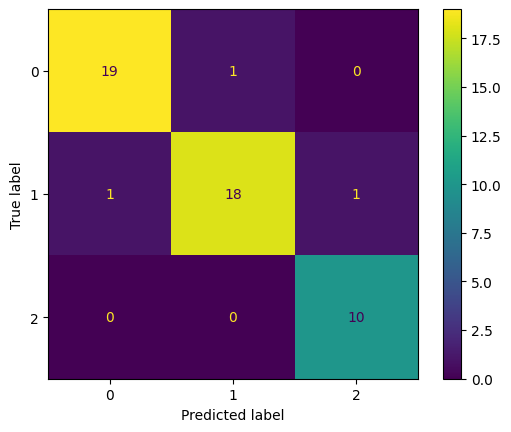

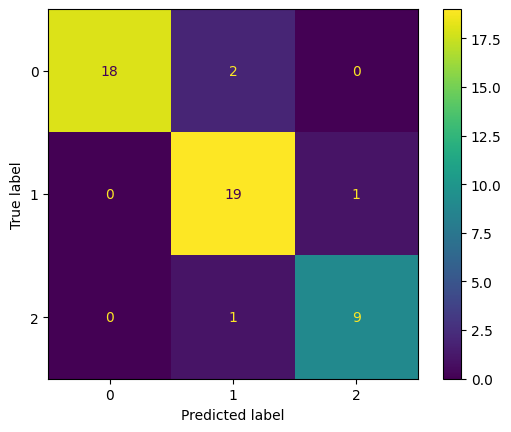

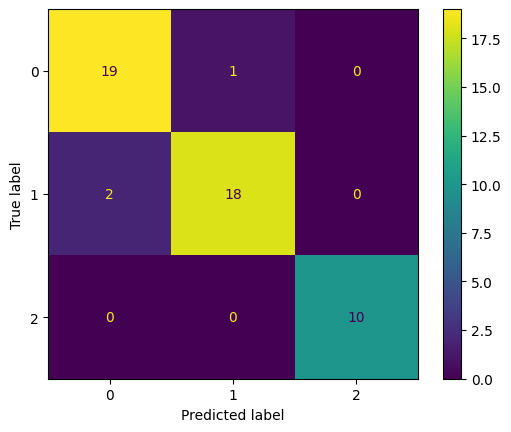

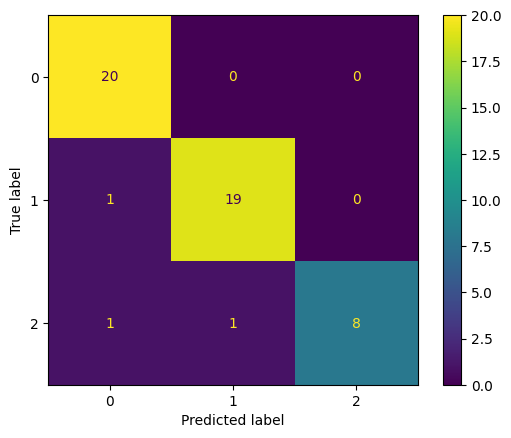

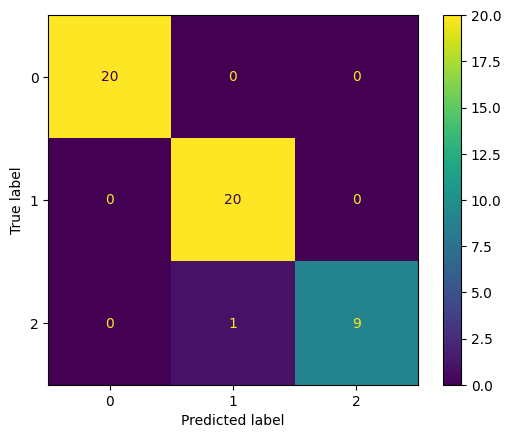

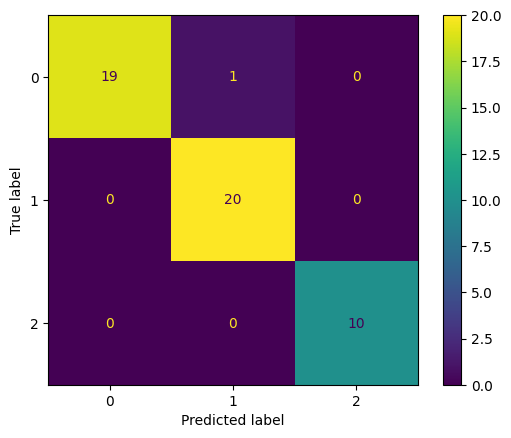

(accuracy     0.954000
 f1           0.953968
 precision    0.956321
 recall       0.954000
 dtype: float64,
    accuracy        f1  precision  recall
 0      0.96  0.960000   0.960000    0.96
 1      0.96  0.960220   0.961818    0.96
 2      0.98  0.979987   0.980952    0.98
 3      0.94  0.940514   0.947826    0.94
 4      0.94  0.939707   0.940766    0.94
 5      0.92  0.920852   0.925455    0.92
 6      0.94  0.939962   0.940852    0.94
 7      0.94  0.938730   0.943636    0.94
 8      0.98  0.979718   0.980952    0.98
 9      0.98  0.979987   0.980952    0.98)

In [ ]:
evaluate_model(xnorm, y, decision_tree)

###Random Forest

In [ ]:
rf=ensemble.RandomForestClassifier(n_estimators=250,criterion='entropy')

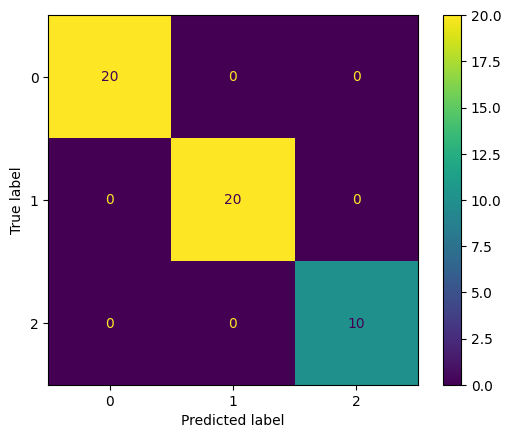

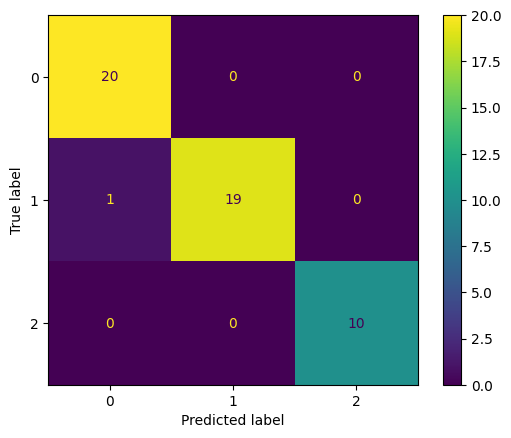

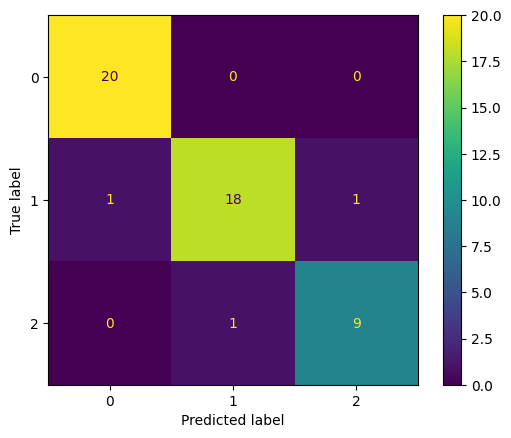

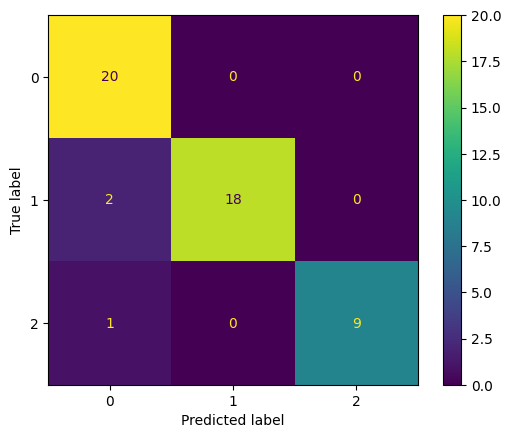

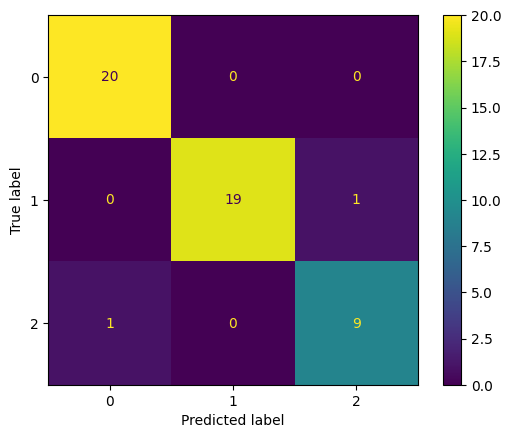

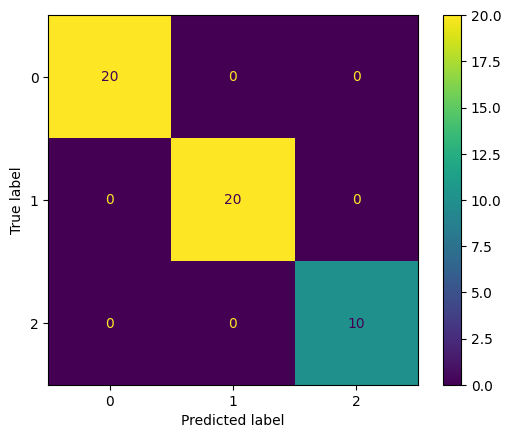

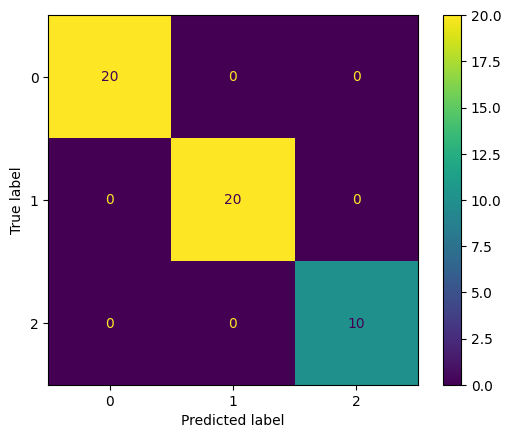

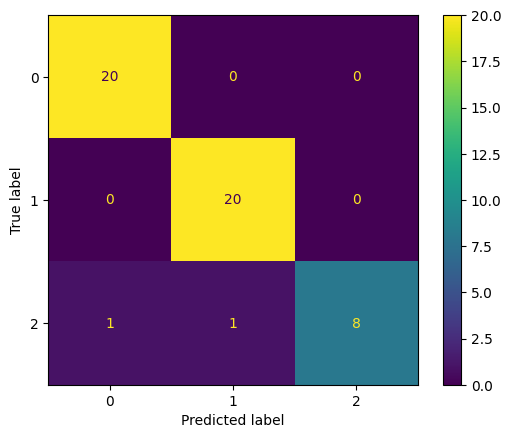

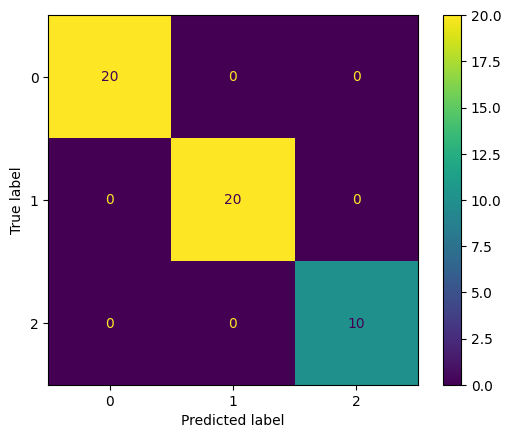

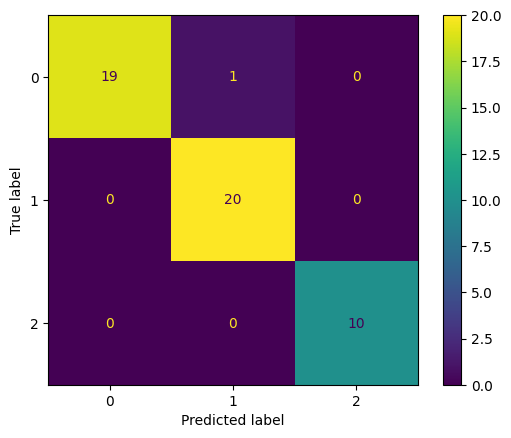

(accuracy     0.976000
 f1           0.975822
 precision    0.977249
 recall       0.976000
 dtype: float64,
    accuracy        f1  precision  recall
 0      1.00  1.000000   1.000000    1.00
 1      0.98  0.979987   0.980952    0.98
 2      0.94  0.939475   0.939900    0.94
 3      0.94  0.940514   0.947826    0.94
 4      0.96  0.959987   0.960952    0.96
 5      1.00  1.000000   1.000000    1.00
 6      1.00  1.000000   1.000000    1.00
 7      0.96  0.958266   0.961905    0.96
 8      1.00  1.000000   1.000000    1.00
 9      0.98  0.979987   0.980952    0.98)

In [ ]:
evaluate_model(xnorm, y, rf)

###SVM

In [ ]:
svc =pipeline.Pipeline([
               ('model' ,svm.SVC( kernel= 'linear'))])


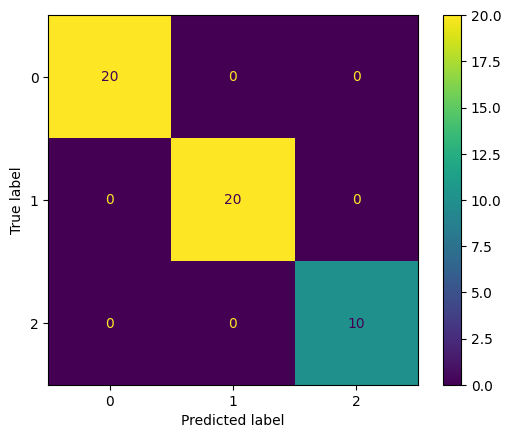

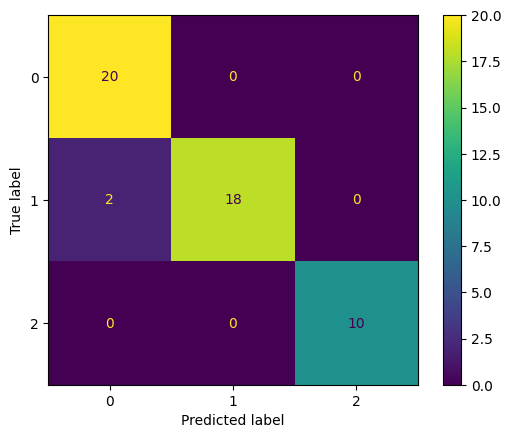

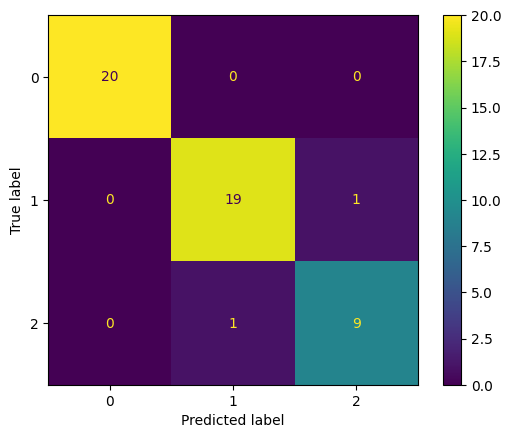

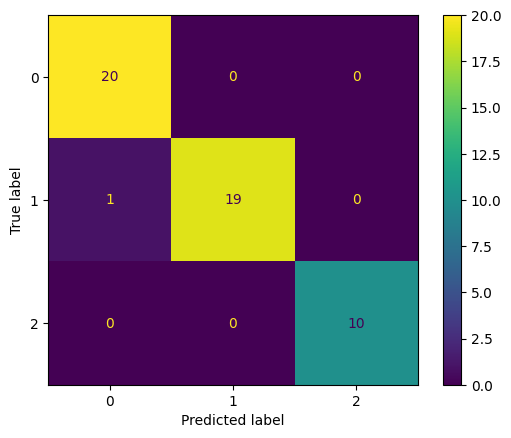

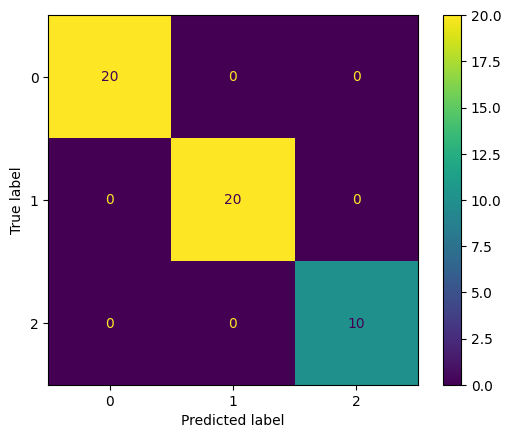

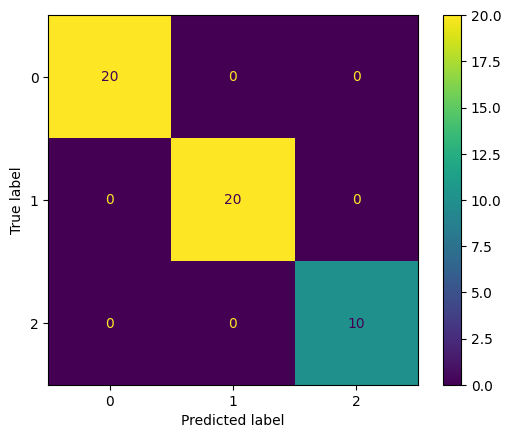

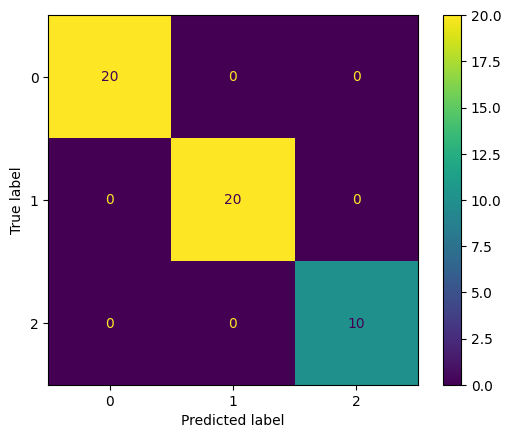

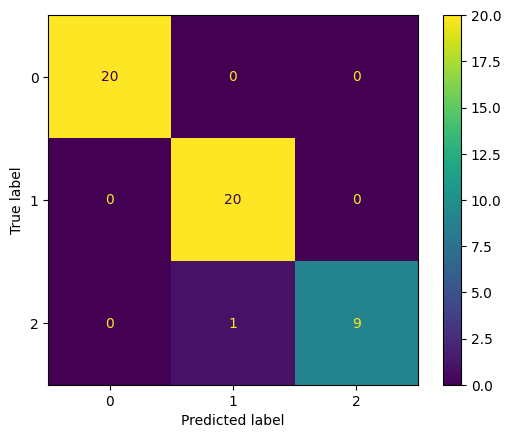

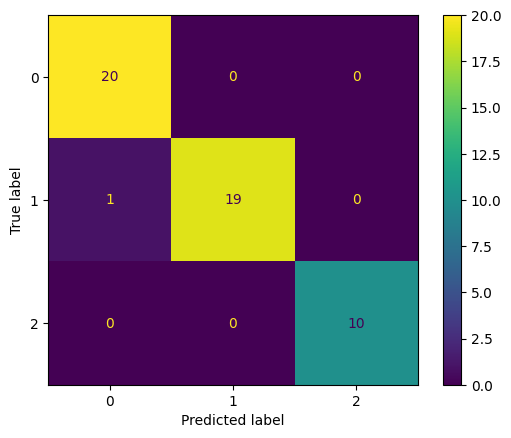

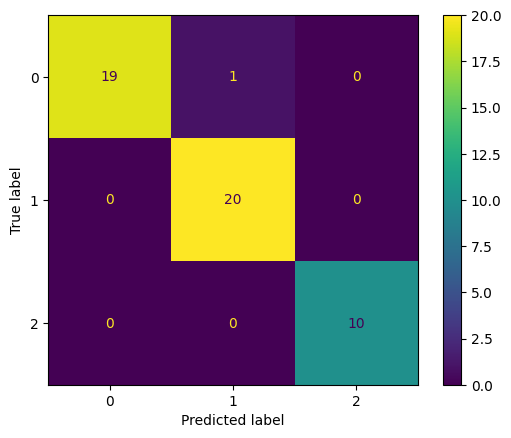

(accuracy     0.984000
 f1           0.983958
 precision    0.984745
 recall       0.984000
 dtype: float64,
    accuracy        f1  precision  recall
 0      1.00  1.000000   1.000000    1.00
 1      0.96  0.959900   0.963636    0.96
 2      0.96  0.960000   0.960000    0.96
 3      0.98  0.979987   0.980952    0.98
 4      1.00  1.000000   1.000000    1.00
 5      1.00  1.000000   1.000000    1.00
 6      1.00  1.000000   1.000000    1.00
 7      0.98  0.979718   0.980952    0.98
 8      0.98  0.979987   0.980952    0.98
 9      0.98  0.979987   0.980952    0.98)

In [ ]:
evaluate_model(xnorm, y, svc)

## Gradient Boosting

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier


In [ ]:
hgb = pipeline.Pipeline([
    ('model', HistGradientBoostingClassifier())
])

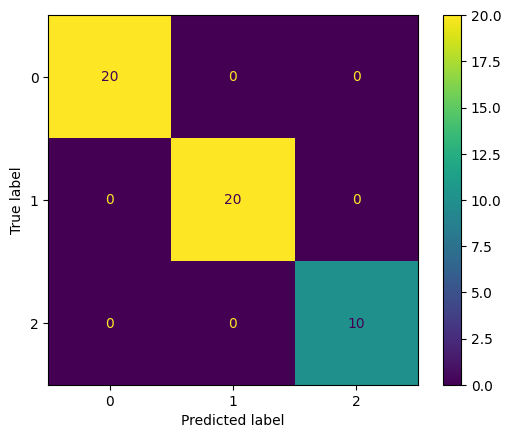

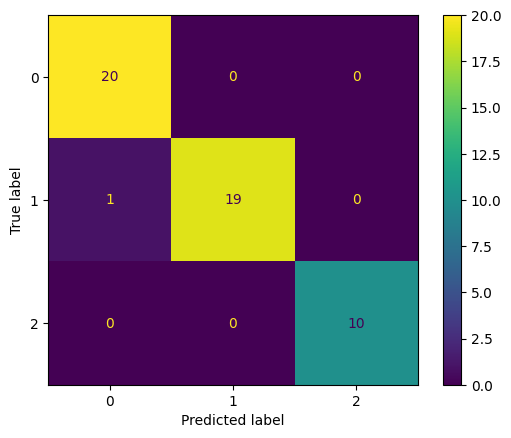

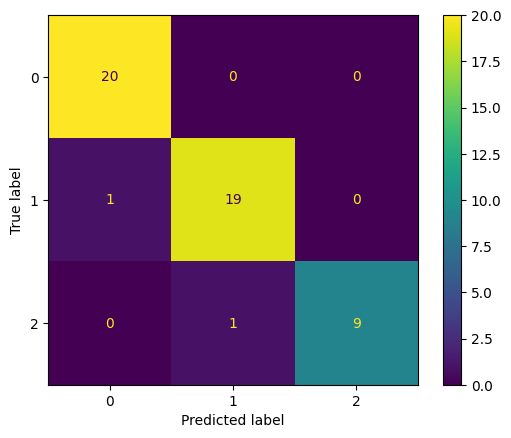

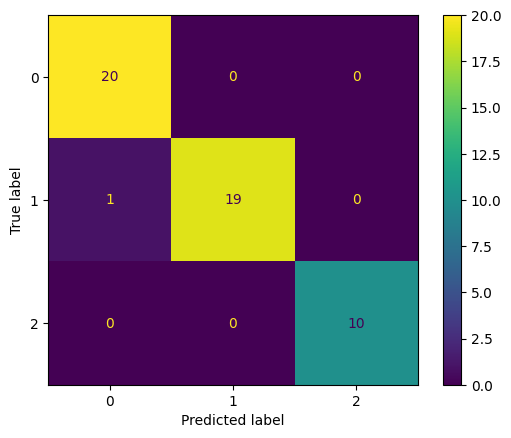

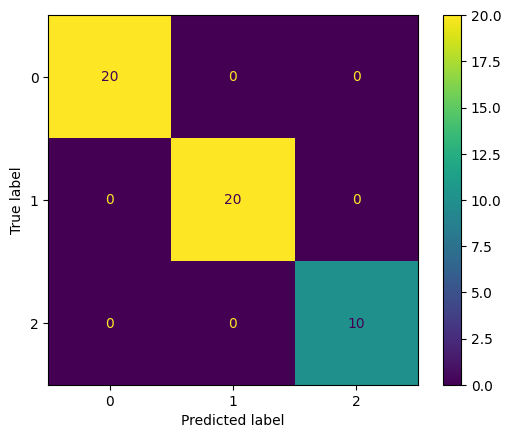

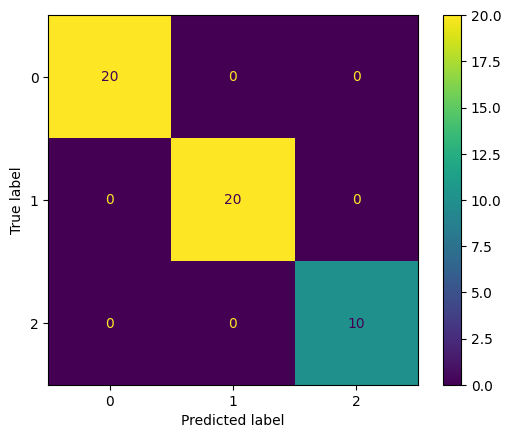

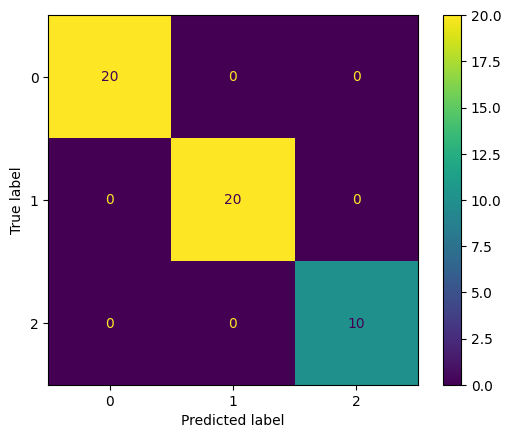

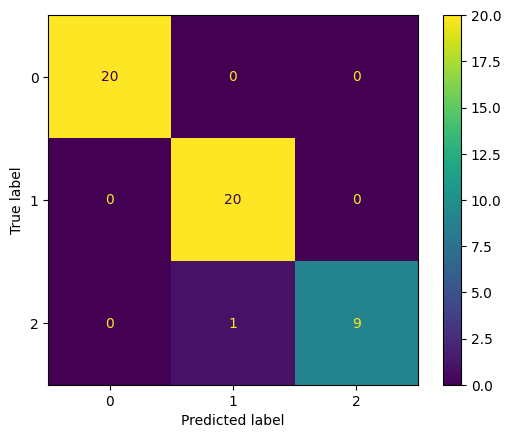

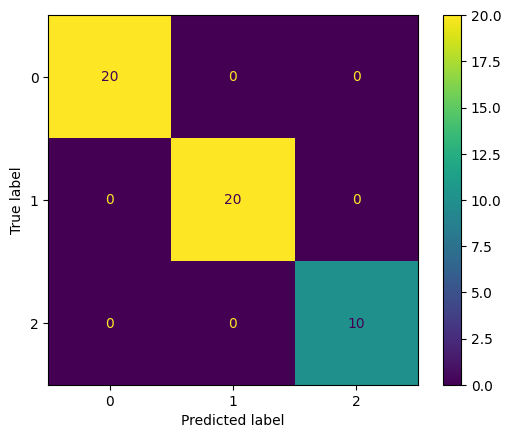

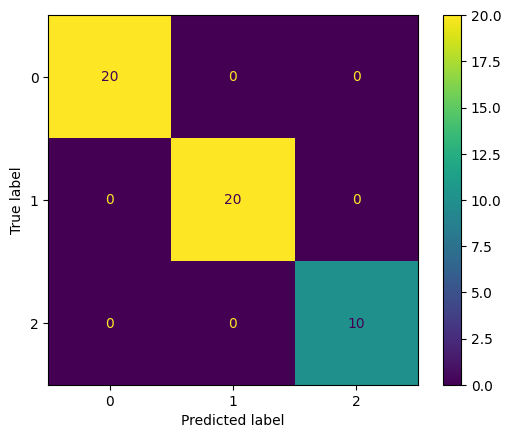

(accuracy     0.990000
 f1           0.989941
 precision    0.990381
 recall       0.990000
 dtype: float64,
    accuracy        f1  precision  recall
 0      1.00  1.000000   1.000000    1.00
 1      0.98  0.979987   0.980952    0.98
 2      0.96  0.959718   0.960952    0.96
 3      0.98  0.979987   0.980952    0.98
 4      1.00  1.000000   1.000000    1.00
 5      1.00  1.000000   1.000000    1.00
 6      1.00  1.000000   1.000000    1.00
 7      0.98  0.979718   0.980952    0.98
 8      1.00  1.000000   1.000000    1.00
 9      1.00  1.000000   1.000000    1.00)

In [ ]:
evaluate_model(xnorm, y, hgb)

## Hyperparameter tuning for Gradient Boosting

## Hyperparameter tuning for Gradient Boosting

In [ ]:
g_classifier = HistGradientBoostingClassifier()

In [ ]:

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_iter': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'l2_regularization': [0.0, 0.1, 0.5],
}


In [ ]:
scoring = {
    "accuracy": metrics.make_scorer(metrics.accuracy_score),
}

In [ ]:
kfold = model_selection.StratifiedShuffleSplit(5, random_state=42)

In [ ]:
gs = model_selection.GridSearchCV(
    g_classifier, param_grid, cv=kfold, scoring=scoring, refit="accuracy", verbose=2
)

In [ ]:

gs.fit(xnorm, y)


In [ ]:

print("Best Hyperparameters:", gs.best_params_)
print("Best Score (Accuracy): ", gs.best_score_)

Best Hyperparameters: {'l2_regularization': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 100}
Best Score (Accuracy):  0.9879999999999999


In [ ]:
hgb = pipeline.Pipeline([
    ('model', HistGradientBoostingClassifier(l2_regularization= 0.0, learning_rate = 0.1, max_depth= 5, max_iter=100))
])


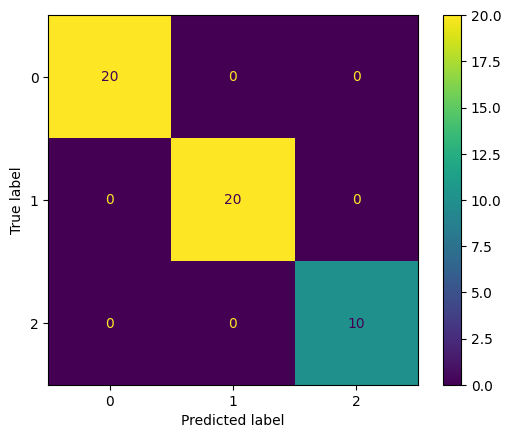

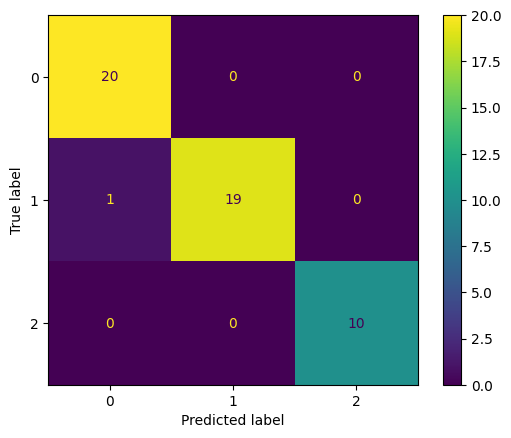

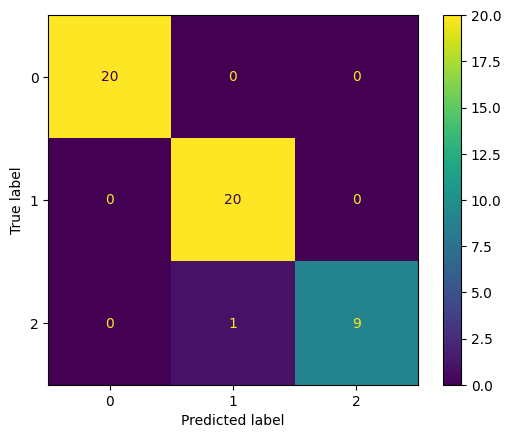

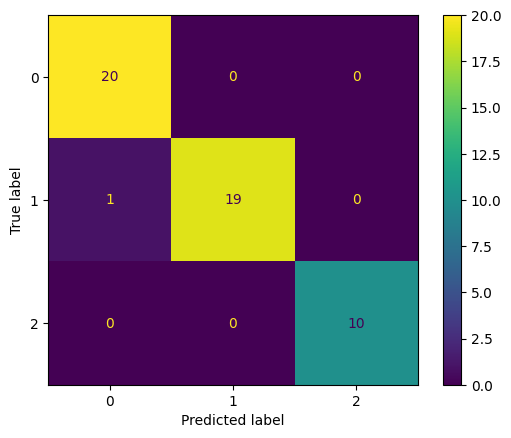

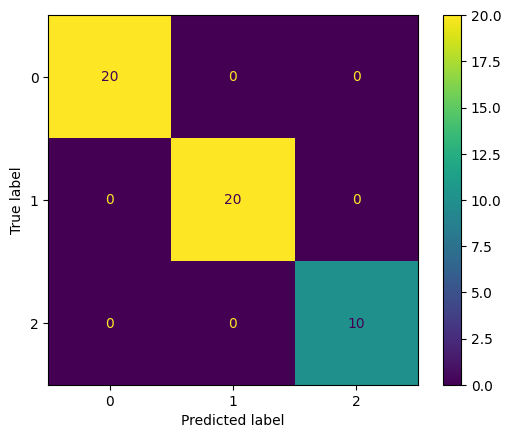

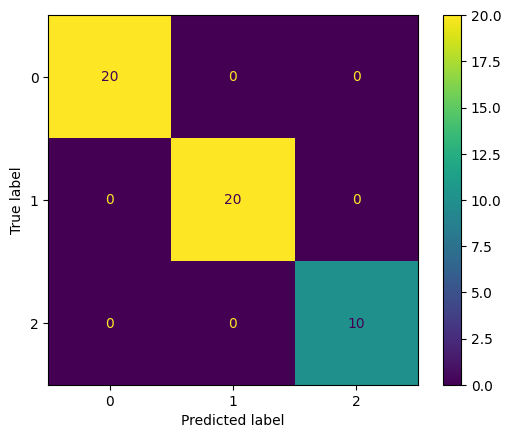

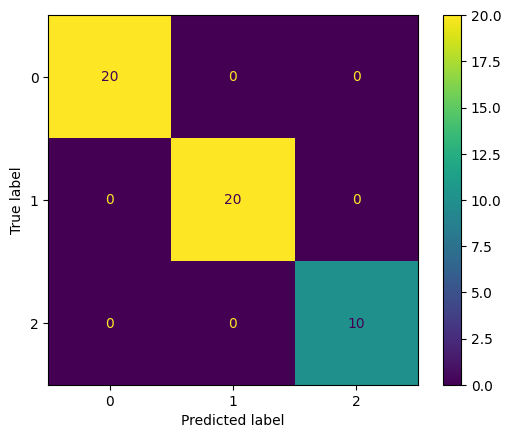

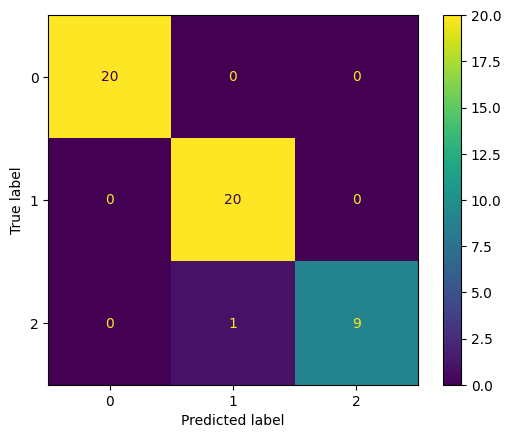

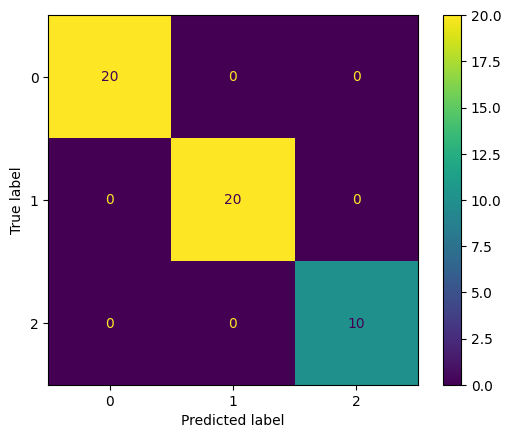

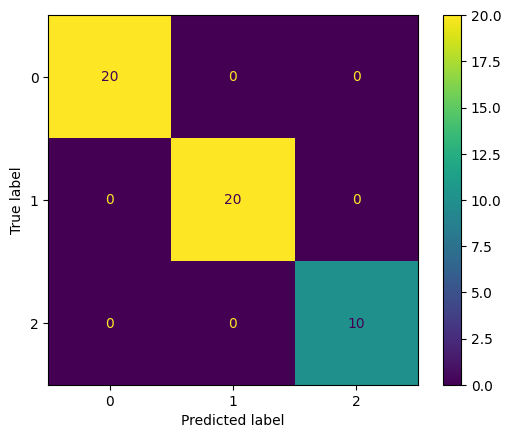

(accuracy     0.992000
 f1           0.991941
 precision    0.992381
 recall       0.992000
 dtype: float64,
    accuracy        f1  precision  recall
 0      1.00  1.000000   1.000000    1.00
 1      0.98  0.979987   0.980952    0.98
 2      0.98  0.979718   0.980952    0.98
 3      0.98  0.979987   0.980952    0.98
 4      1.00  1.000000   1.000000    1.00
 5      1.00  1.000000   1.000000    1.00
 6      1.00  1.000000   1.000000    1.00
 7      0.98  0.979718   0.980952    0.98
 8      1.00  1.000000   1.000000    1.00
 9      1.00  1.000000   1.000000    1.00)

In [ ]:
evaluate_model(xnorm, y, hgb)